In [229]:
## Imports

import math
import numpy as np
import pandas as pd
import scipy.stats

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

## Data Imports
- Original Data located in root directory

In [230]:
train = pd.read_csv('../Data/train.csv', index_col='Id')
test = pd.read_csv('../Data/test.csv', index_col='Id')

train_cols = ['SalePrice', 'LotFrontage', 'LotArea', 'Neighborhood', 'OverallQual', 'OverallCond', 'YearBuilt', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'KitchenQual', 'TotRmsAbvGrd', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', '3SsnPorch', 'ScreenPorch', 'EnclosedPorch', 'GarageArea']
test_cols = ['LotFrontage', 'LotArea', 'Neighborhood', 'OverallQual', 'OverallCond', 'YearBuilt', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', '1stFlrSF', 'TotalBsmtSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'KitchenQual', 'TotRmsAbvGrd', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', '3SsnPorch', 'ScreenPorch', 'EnclosedPorch', 'GarageArea']

train = train[train_cols]
test = test[test_cols]

train['TotalSF'] = train.TotalBsmtSF + train.GrLivArea
train['TotalPorchSF'] = train.OpenPorchSF + train.EnclosedPorch + train['3SsnPorch'] + train.ScreenPorch

test['TotalSF'] = test.TotalBsmtSF + test.GrLivArea
test['TotalPorchSF'] = test.OpenPorchSF + test.EnclosedPorch + \
    test['3SsnPorch'] + test.ScreenPorch

train['TotalBaths'] = train.FullBath + (.5 * train.HalfBath) + train.BsmtFullBath + (.5 * train.BsmtHalfBath)
test['TotalBaths'] = test.FullBath + (.5 * test.HalfBath) + test.BsmtFullBath + (.5 * test.BsmtHalfBath)

train['YearsOld'] = 2022 - train['YearBuilt']
test['YearsOld'] = 2022 - test['YearBuilt']

# We heed the author's advice and cut out anything over 4,000 sq ft
train.drop(train[train.GrLivArea >= 4000].index, inplace=True)

# We heed the author's advice and cut out anything over 4,000 sq ft
test.drop(test[test.GrLivArea >= 4000].index, inplace=True)

# LotFrontage is "Linear feet of street connected to property"
# Since it seems unlikely that there's no street connected
# to a lot, we'll set it equal to the median LotFrontage of that street.
train.LotFrontage = train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

train = train.drop(columns=['TotalBsmtSF', 'GrLivArea', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', '1stFlrSF', '2ndFlrSF', 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', 'YearBuilt'])
test = test.drop(columns=['TotalBsmtSF', 'GrLivArea', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', '1stFlrSF', '2ndFlrSF', 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', 'YearBuilt'])

train.head(5)

,SalePrice,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,KitchenQual,TotRmsAbvGrd,GarageQual,GarageCond,WoodDeckSF,GarageArea,TotalSF,TotalPorchSF,TotalBaths,YearsOld
Id,,,,,,,,,,,,,,,,,,,,
1,208500,65.0,8450,CollgCr,7,5,Gd,TA,Gd,TA,Gd,8,TA,TA,0,548,2566,61,3.5,19
2,181500,80.0,9600,Veenker,6,8,TA,TA,Gd,TA,TA,6,TA,TA,298,460,2524,0,2.5,46
3,223500,68.0,11250,CollgCr,7,5,Gd,TA,Gd,TA,Gd,6,TA,TA,0,608,2706,42,3.5,21
4,140000,60.0,9550,Crawfor,7,5,TA,TA,TA,Gd,Gd,7,TA,TA,0,642,2473,307,2.0,107
5,250000,84.0,14260,NoRidge,8,5,Gd,TA,Gd,TA,Gd,9,TA,TA,192,836,3343,84,3.5,22


## Function Definition for getting feature types (categorical vs numerical)

In [231]:
def get_feature_groups():
    """ Returns a list of numerical and categorical features,
    excluding SalePrice and Id. """
    # Numerical Features
    num_features = train.select_dtypes(include=['int64','float64']).columns
    num_features = num_features.drop(['SalePrice']) # drop ID and SalePrice

    # Categorical Features
    cat_features = train.select_dtypes(include=['object']).columns
    return list(num_features), list(cat_features)

num_features, cat_features = get_feature_groups()

# Categorical features with "NA" values
missing_values = (train[cat_features] == 'NA').sum().sort_values(ascending=False)
missing_values[missing_values > 0]

Series([], dtype: int64)

## Analysis of numerical features

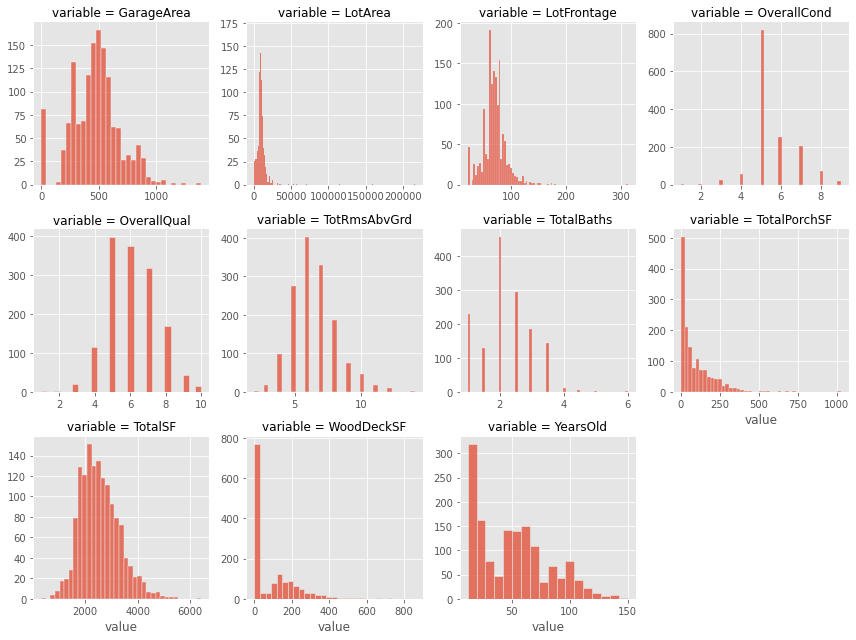

In [232]:
# Grid of distribution plots of all numerical features
f = pd.melt(train, value_vars=sorted(num_features))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.histplot, 'value')

## Categorical Features

c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


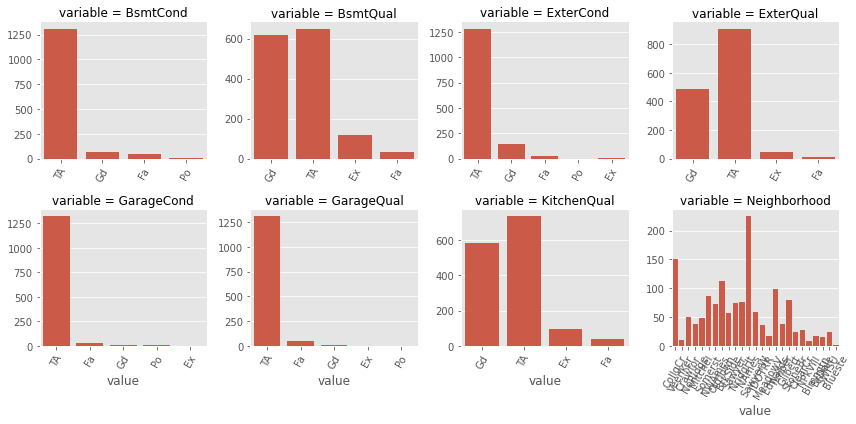

In [233]:
# Count plots of categorical features
f = pd.melt(train, value_vars=sorted(cat_features))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.countplot, 'value')
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

## Numerical Scatterplots against SalePrice

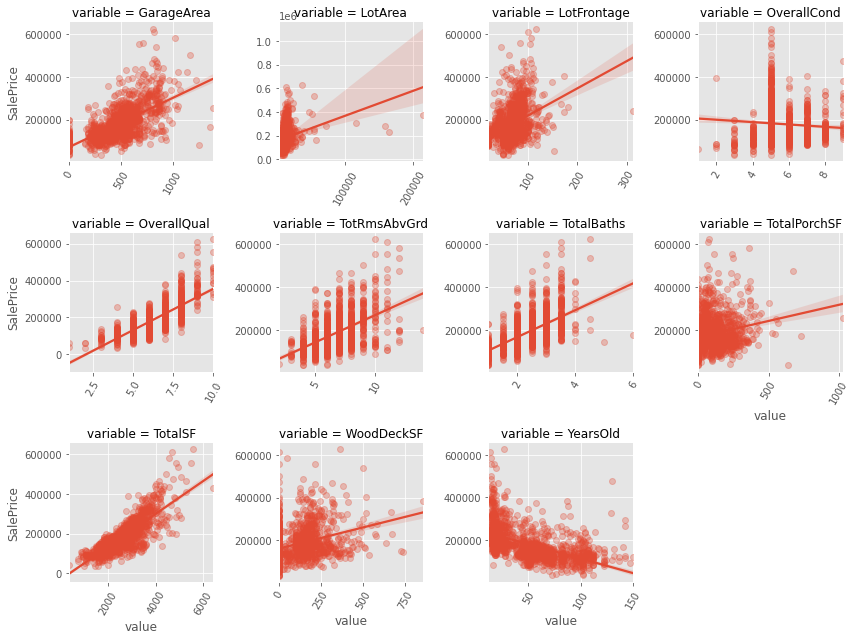

In [234]:
f = pd.melt(train, id_vars=['SalePrice'], value_vars=sorted(num_features))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.regplot, 'value', 'SalePrice', scatter_kws={'alpha':0.3})
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

## Now, we will evaluate the correlated between numerical features

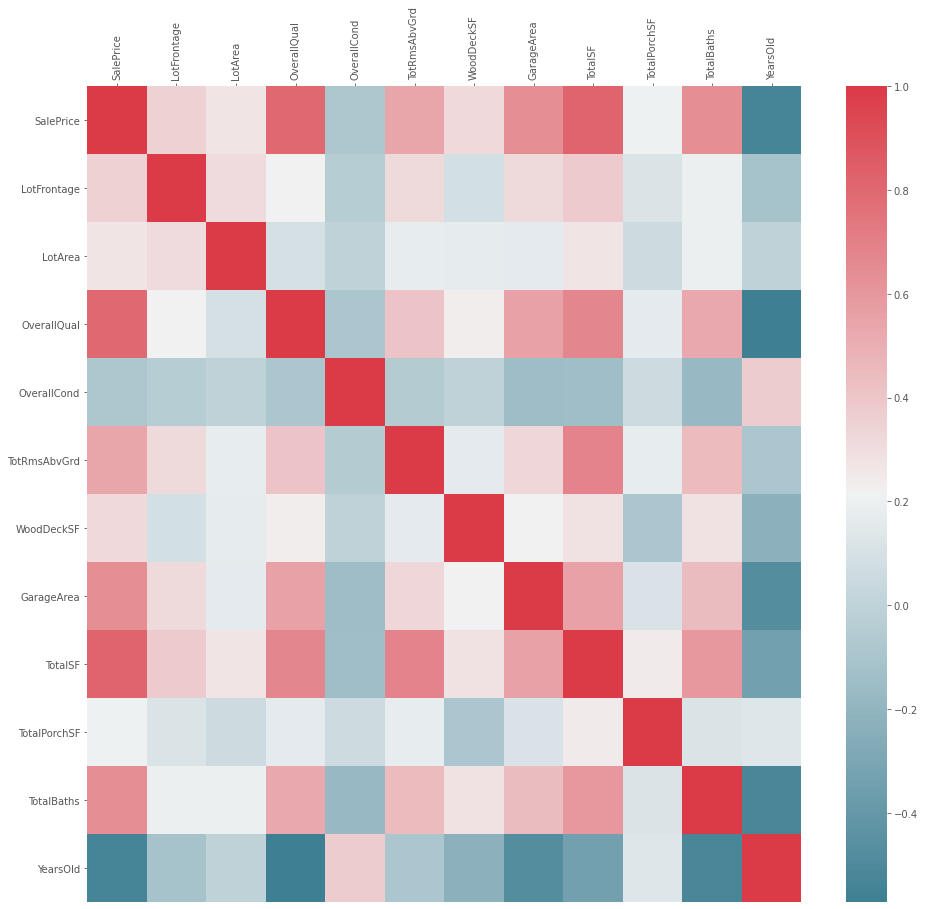

In [235]:
corr = train[['SalePrice'] + num_features].corr()
fig = plt.figure(figsize=(16,15))
ax = fig.add_subplot(111)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, 
           xticklabels=corr.columns.values,
           yticklabels=corr.index.values,
           cmap=cmap)
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

## Correlation with Sale Price

c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


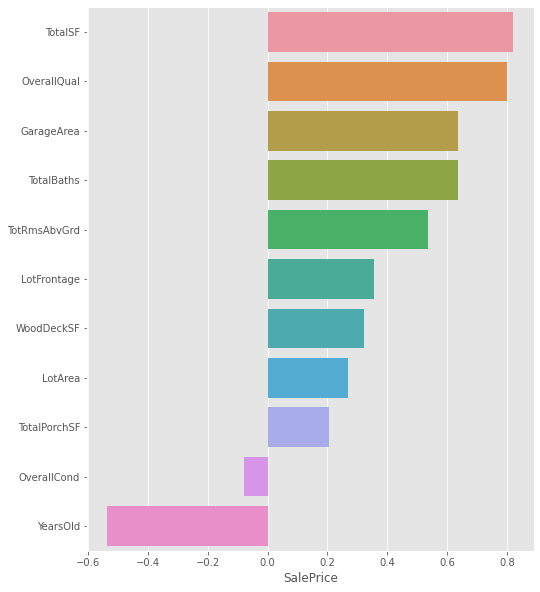

In [236]:
corr = corr.sort_values('SalePrice', ascending=False)
plt.figure(figsize=(8,10))
sns.barplot( corr.SalePrice[1:], corr.index[1:], orient='h')
plt.show()

## Boxplots for categorical features

c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


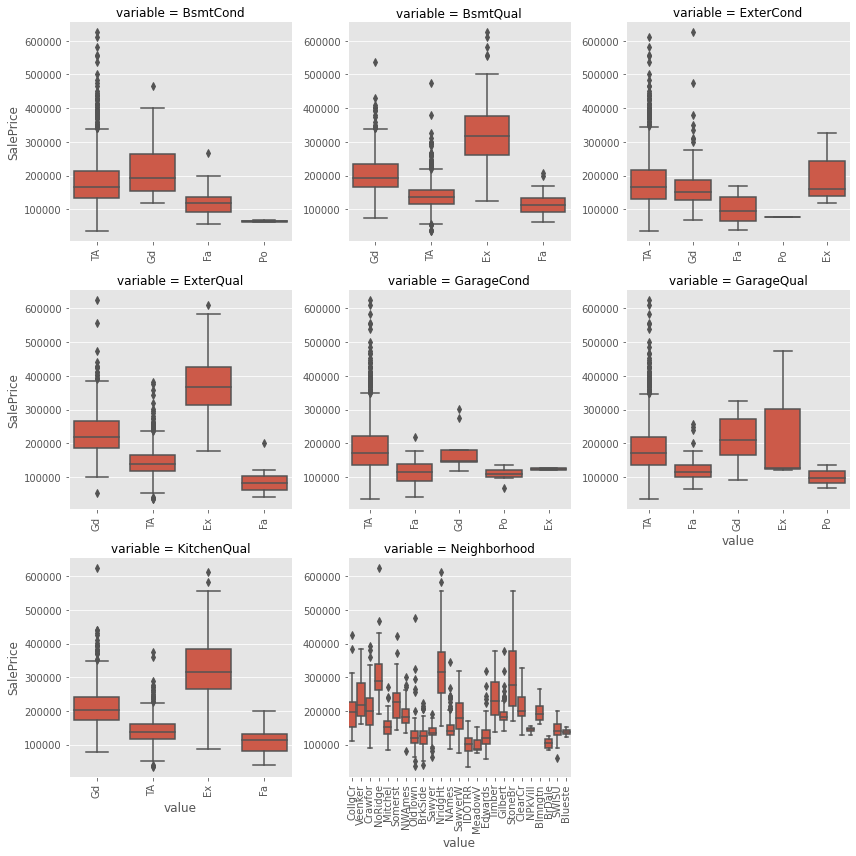

In [237]:
f = pd.melt(train, id_vars=['SalePrice'], value_vars=sorted(cat_features))
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False, size=4)
g = g.map(sns.boxplot, 'value', 'SalePrice')
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

## One Way ANOVA for all categorical variables

In [238]:
# In order for ANOVA to work, we have to take care of missing values first
train[cat_features] = train[cat_features].fillna('NA')

# Onward...
anova = {'feature':[], 'f':[], 'p':[]}
for cat in cat_features:
    group_prices = []
    for group in train[cat].unique():
        group_prices.append(train[train[cat] == group]['SalePrice'].values)
    f, p = scipy.stats.f_oneway(*group_prices)
    anova['feature'].append(cat)
    anova['f'].append(f)
    anova['p'].append(p)
anova = pd.DataFrame(anova)
anova = anova[['feature','f','p']]
anova.sort_values('p', inplace=True)

anova['significant'] = anova['p'] < .01

display(anova)

,feature,f,p,significant
0,Neighborhood,74.023903,1.633204e-230,True
1,ExterQual,474.581115,7.344575e-215,True
3,BsmtQual,324.463395,1.664157e-199,True
5,KitchenQual,417.266766,1.951953e-195,True
6,GarageQual,27.252579,1.987542e-26,True
7,GarageCond,27.188831,2.292018e-26,True
4,BsmtCond,20.948362,8.300501e-17,True
2,ExterCond,9.152153,2.658076e-07,True


## Data Preprocessing and Regression

In [239]:
## Let's log transform any features that have a skew of more than .5

skewed_num_features = []

for feature in num_features:
    if train[feature].skew() > .5:
        skewed_num_features.append(feature)

print('Skewed Features:',skewed_num_features)
print('Number of Skewed Features:',len(skewed_num_features))

for feature in skewed_num_features:
    train[feature] = np.log1p(train[feature])

## Also Transform Sale Price
train['SalePrice'] = np.log1p(train['SalePrice'])

Skewed Features: ['LotFrontage', 'LotArea', 'OverallCond', 'TotRmsAbvGrd', 'WoodDeckSF', 'TotalSF', 'TotalPorchSF', 'YearsOld']
Number of Skewed Features: 8


## Dummy Variables

In [240]:
# before we continue, let's drop some cols
y = train['SalePrice']
train.drop('SalePrice', axis=1, inplace=True)

In [241]:
# ... and go
model_data = pd.get_dummies(train).copy()

display(model_data)
display(y)

,LotFrontage,LotArea,OverallQual,OverallCond,TotRmsAbvGrd,WoodDeckSF,GarageArea,TotalSF,TotalPorchSF,TotalBaths,...,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA
Id,,,,,,,,,,,,,,,,,,,,,
1,4.189655,9.042040,7,1.791759,2.197225,0.000000,548,7.850493,4.127134,3.5,...,0,0,0,1,0,0,0,0,0,1
2,4.394449,9.169623,6,2.197225,1.945910,5.700444,460,7.833996,0.000000,2.5,...,0,0,0,1,0,0,0,0,0,1
3,4.234107,9.328212,7,1.791759,1.945910,0.000000,608,7.903596,3.761200,3.5,...,0,0,0,1,0,0,0,0,0,1
4,4.110874,9.164401,7,1.791759,2.079442,0.000000,642,7.813592,5.730100,2.0,...,0,0,0,1,0,0,0,0,0,1
5,4.442651,9.565284,8,1.791759,2.302585,5.262690,836,8.114923,4.442651,3.5,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,4.143135,8.976894,6,1.791759,2.079442,0.000000,460,7.863651,3.713572,2.5,...,0,0,0,1,0,0,0,0,0,1
1457,4.454347,9.486152,6,1.945910,2.079442,5.857933,500,8.193124,0.000000,3.0,...,0,0,0,1,0,0,0,0,0,1
1458,4.204693,9.109746,7,2.302585,2.302585,0.000000,252,8.158516,4.110874,2.0,...,0,0,0,1,0,0,0,0,0,1


Id
1       12.247699
2       12.109016
3       12.317171
4       11.849405
5       12.429220
          ...    
1456    12.072547
1457    12.254868
1458    12.493133
1459    11.864469
1460    11.901590
Name: SalePrice, Length: 1456, dtype: float64

## Standardization

In [242]:
# Split data intro train and validation sets
X_train, X_test, y_train, y_test = train_test_split(model_data.copy(), y, test_size=0.3, random_state=42)
print('Shapes')
print('X_train:', X_train.shape)
print('X_val:', X_test.shape)
print('y_train:', y_train.shape)
print('y_val:', y_test.shape)

Shapes
X_train: (1019, 71)
X_val: (437, 71)
y_train: (1019,)
y_val: (437,)


In [243]:
stdscl = StandardScaler()

X_train.loc[:,num_features] = stdscl.fit_transform(X_train[num_features])
X_test.loc[:,num_features] = stdscl.transform(X_test[num_features])

## SLR WITH ALL OUR VARIABLES

In [244]:
def model_evaluation_plots(model, X_train, y_train, X_test, y_test):
    y_train_preds = model.predict(X_train)
    y_test_preds = model.predict(X_test)
    
    plt.figure(figsize=(12,6))
    # Residuals
    plt.subplot(121)
    plt.scatter(y_train_preds, y_train_preds - y_train, c='blue', marker='o', label='Training data')
    plt.scatter(y_test_preds, y_test_preds - y_test, c='orange', marker='s', label='Validation data')
    plt.title('Residuals')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=y_train.min(), xmax=y_train.max(), color='red')

    # Predictions
    plt.subplot(122)
    plt.scatter(y_train_preds, y_train, c='blue', marker='o', label='Training data')
    plt.scatter(y_test_preds, y_test, c='orange', marker='s', label='Validation data')
    plt.title('Predictions')
    plt.xlabel('Predicted values')
    plt.ylabel('Real values')
    plt.legend(loc='upper left')
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c='red')
    plt.tight_layout()
    plt.show()

import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))


explained_variance:  0.9133
mean_squared_log_error:  0.0158
r2:  0.9123
MAE:  14760.4196
MSE:  440235696.4636
RMSE:  20981.7944
Mean Absolute Error: 14760.419609767407
Mean Squared Error: 440235696.4635828
Root Mean Squared Error: 20981.794405235763


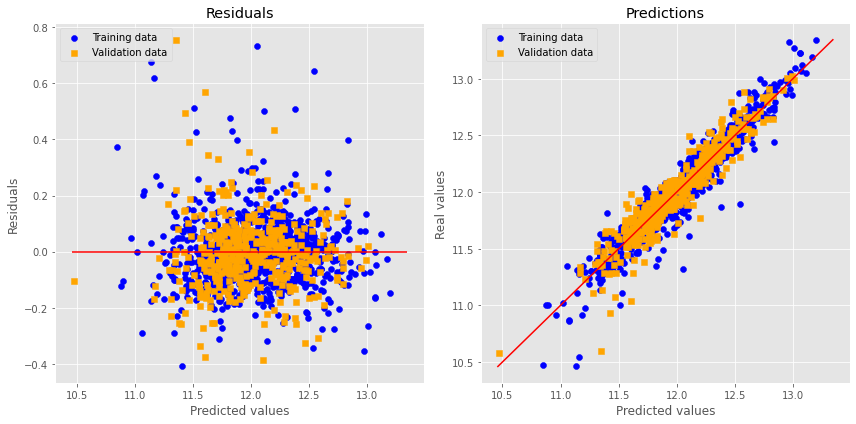

In [245]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

df = pd.DataFrame({'Actual': np.expm1(y_test), 'Predicted': np.expm1(y_pred)})
df

regression_results(np.expm1(y_test), np.expm1(y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(np.expm1(y_test), np.expm1(y_pred)))  
print('Mean Squared Error:', metrics.mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.expm1(y_test), np.expm1(y_pred))))

model_evaluation_plots(lr, X_train, y_train, X_test, y_test)


In [263]:
from statsmodels.api import OLS
from statsmodels.api import graphics
stats_model = OLS(y_train,X_train).fit()
stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     178.0
Date:                Thu, 28 Jul 2022   Prob (F-statistic):               0.00
Time:                        01:06:42   Log-Likelihood:                 768.53
No. Observations:                1019   AIC:                            -1413.
Df Residuals:                     957   BIC:                            -1108.
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
LotFrontage              0.0020      0.006      0.348      0.728      -0.009       0.013
LotArea                  0.0555      0.006      8.901      0.000       0.043       0.068
OverallQual              0.0790      0.007     10.571      0.000       0.064       0.094
OverallCond              0.0610      0.005     12.226      0.000       0.051       0.071
TotRmsAbvGrd             0.0079      0.006      1.353      0.176      -0.004       0.019
WoodDeckSF               0.0107      0.004      2.551      0.011       0.002       0.019
GarageArea               0.0236      0.006      3.832      0.000       0.012       0.036
TotalSF                  0.1290      0.009     15.119      0.000       0.112       0.146
TotalPorchSF             0.0138      0.004      3.297      0.001       0.006       0.022
TotalBaths               0.0463      0.005      8.439      0.000       0.036       0.057
YearsOld                -0.0815      0.011     -7.519      0.000      -0.103      -0.060
Neighborhood_Blmngtn     0.3553      0.034     10.410      0.000       0.288       0.422
Neighborhood_Blueste     0.4091      0.115      3.551      0.000       0.183       0.635
Neighborhood_BrDale      0.3435      0.043      7.969      0.000       0.259       0.428
Neighborhood_BrkSide     0.3674      0.023     16.169      0.000       0.323       0.412
Neighborhood_ClearCr     0.3568      0.029     12.188      0.000       0.299       0.414
Neighborhood_CollgCr     0.3089      0.016     19.471      0.000       0.278       0.340
Neighborhood_Crawfor     0.4650      0.022     21.121      0.000       0.422       0.508
Neighborhood_Edwards     0.2559      0.017     14.964      0.000       0.222       0.289
Neighborhood_Gilbert     0.2975      0.021     14.476      0.000       0.257       0.338
Neighborhood_IDOTRR      0.1718      0.027      6.275      0.000       0.118       0.226
Neighborhood_MeadowV     0.2757      0.044      6.264      0.000       0.189       0.362
Neighborhood_Mitchel     0.2618      0.022     12.132      0.000       0.219       0.304
Neighborhood_NAmes       0.3092      0.014     21.924      0.000       0.282       0.337
Neighborhood_NPkVill     0.3643      0.049      7.444      0.000       0.268       0.460
Neighborhood_NWAmes      0.2740      0.018     14.886      0.000       0.238       0.310
Neighborhood_NoRidge     0.4512      0.025     18.021      0.000       0.402       0.500
Neighborhood_NridgHt     0.3553      0.022     16.304      0.000       0.313       0.398
Neighborhood_OldTown     0.2342      0.019     12.105      0.000       0.196       0.272
Neighborhood_SWISU       0.3017      0.037      8.186      0.000       0.229       0.374
Neighborhood_Sawyer      0.2950      0.019     15.390      0.000       0.257       0.333
Neighborhood_SawyerW     0.2783      0.020     13.764    

In [253]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]

display(vif_data.head(10))

c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,LotFrontage,2.398304
1,LotArea,2.871485
2,OverallQual,4.123252
3,OverallCond,1.837347
4,TotRmsAbvGrd,2.505442
5,WoodDeckSF,1.293392
6,GarageArea,2.803882
7,TotalSF,5.378485
8,TotalPorchSF,1.287198
9,TotalBaths,2.221591


## Ridge

Ridge(alpha=4.75)


,Actual,Predicted
Id,,
498,184000.0,184761.175069
1265,181000.0,177858.970209
412,145000.0,147606.785496
1049,115000.0,122274.236356
1036,84000.0,71187.622581
...,...,...
324,126175.0,118870.526085
1290,281000.0,276248.962720
727,222000.0,277426.717807


Mean Absolute Error: 14412.214807745171
Mean Squared Error: 424830196.9839771
Root Mean Squared Error: 20611.409388588087


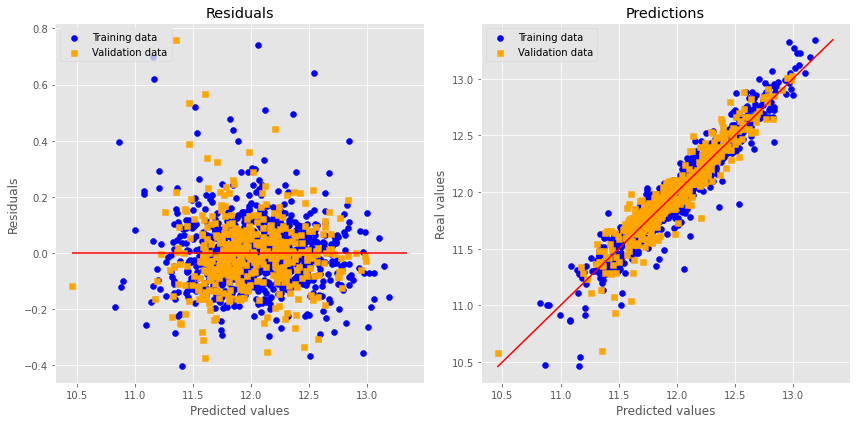

explained_variance:  0.9162
mean_squared_log_error:  0.0155
r2:  0.9153
MAE:  14412.2148
MSE:  424830196.984
RMSE:  20611.4094


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# We're using GridSearch here to find the optimal alpha value
# Get the ballpark
param_grid = {'alpha': [0.01, 0.1, 1., 5., 10., 25., 50., 100.]}
ridge = GridSearchCV(Ridge(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
ridge.fit(X_train, y_train)
alpha = ridge.best_params_['alpha']

# Hone in
param_grid = {'alpha': [x/100. * alpha for x in range(50, 150, 5)]}
ridge = GridSearchCV(Ridge(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
ridge.fit(X_train, y_train)
alpha = ridge.best_params_['alpha']
ridge = ridge.best_estimator_

print(ridge)

y_pred = ridge.predict(X_test)

df = pd.DataFrame({'Actual': np.expm1(y_test), 'Predicted': np.expm1(y_pred)})
display(df)

print('Mean Absolute Error:', metrics.mean_absolute_error(np.expm1(y_test), np.expm1(y_pred)))  
print('Mean Squared Error:', metrics.mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.expm1(y_test), np.expm1(y_pred))))

model_evaluation_plots(ridge, X_train, y_train, X_test, y_test)

regression_results(np.expm1(y_test), np.expm1(y_pred))


Ridge dropped 0 of 71 features.


c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


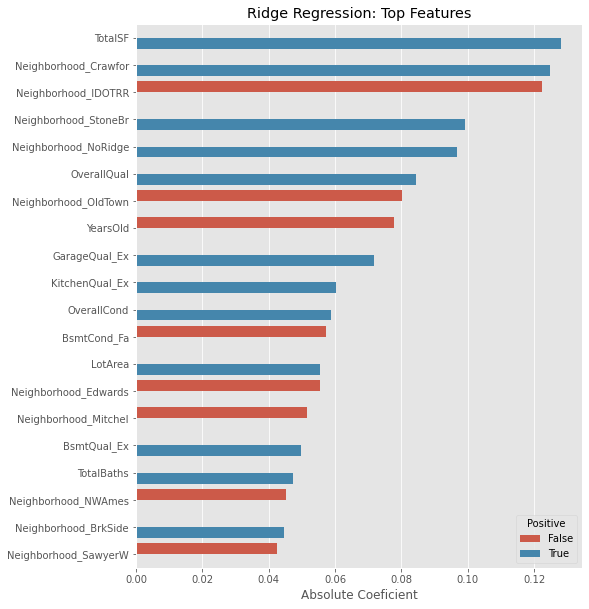

In [ ]:
# Let's take a look at what the Ridge regression made of our features.
coefs = pd.DataFrame({'coefs':ridge.coef_,'Positive':ridge.coef_ > 0}, index=X_train.columns)
coefs['coefs_abs'] = np.abs(coefs.coefs)
print('Ridge dropped {} of {} features.'.format(
    sum(coefs.coefs == 0), coefs.shape[0]))

top_coefs = coefs.sort_values('coefs_abs', ascending=False).head(20)
plt.figure(figsize=(8,10))
sns.barplot( top_coefs.coefs_abs, top_coefs.index, orient='h', hue=top_coefs.Positive)
plt.title('Ridge Regression: Top Features')
plt.xlabel('Absolute Coeficient')
plt.show()

## LASSO

Lasso(alpha=0.00011499999999999999, max_iter=50000)


,Actual,Predicted
Id,,
498,184000.0,184681.603377
1265,181000.0,176944.246298
412,145000.0,147882.556691
1049,115000.0,121723.529706
1036,84000.0,70955.253649
...,...,...
324,126175.0,119627.393246
1290,281000.0,275659.481263
727,222000.0,279499.310433


Mean Absolute Error: 14568.591576981384
Mean Squared Error: 432219972.49094594
Root Mean Squared Error: 20789.900733070997


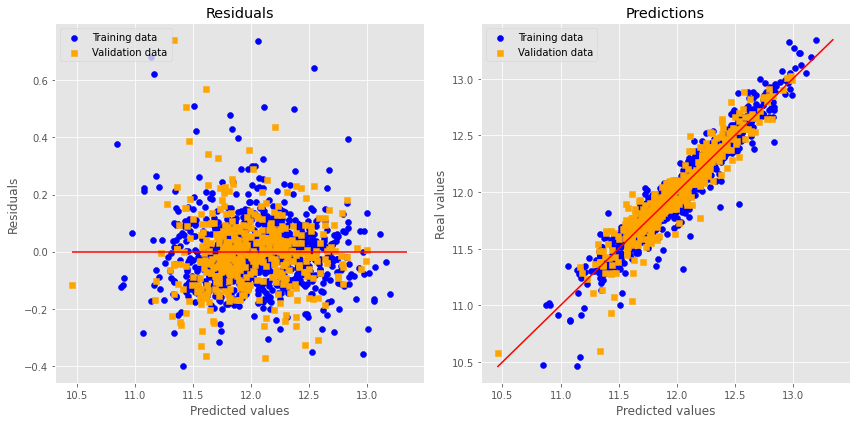

explained_variance:  0.9148
mean_squared_log_error:  0.0156
r2:  0.9139
MAE:  14568.5916
MSE:  432219972.4909
RMSE:  20789.9007


In [ ]:
from sklearn.linear_model import Lasso

# We're using GridSearch here to find the optimal alpha value
# Get the ballpark
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1., 5., 10., 25.], 'max_iter': [50000]}
lasso = GridSearchCV(Lasso(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
lasso.fit(X_train, y_train)
alpha = lasso.best_params_['alpha']

# Hone in
param_grid = {'alpha': [x/100. * alpha for x in range(50, 150, 5)], 'max_iter': [50000]}
lasso = GridSearchCV(Lasso(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
lasso.fit(X_train, y_train)
alpha = lasso.best_params_['alpha']
lasso = lasso.best_estimator_

print(lasso)

y_pred = lasso.predict(X_test)

df = pd.DataFrame({'Actual': np.expm1(y_test), 'Predicted': np.expm1(y_pred)})
display(df)

print('Mean Absolute Error:', metrics.mean_absolute_error(np.expm1(y_test), np.expm1(y_pred)))  
print('Mean Squared Error:', metrics.mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.expm1(y_test), np.expm1(y_pred))))

model_evaluation_plots(lasso, X_train, y_train, X_test, y_test)

regression_results(np.expm1(y_test), np.expm1(y_pred))


LASSO dropped 14 of 71 features.


c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


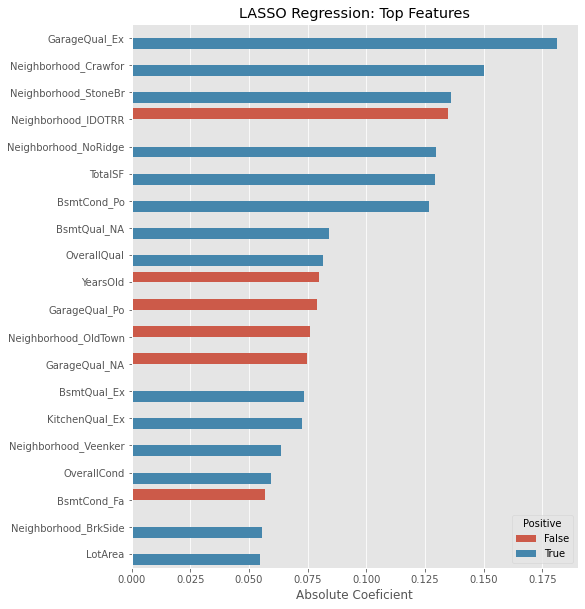

In [ ]:
# Let's take a look at what the LASSO regression made of our features.
coefs = pd.DataFrame({'coefs':lasso.coef_,'Positive':lasso.coef_ > 0}, index=X_train.columns)
coefs['coefs_abs'] = np.abs(coefs.coefs)
print('LASSO dropped {} of {} features.'.format(
    sum(coefs.coefs == 0), coefs.shape[0]))

top_coefs = coefs.sort_values('coefs_abs', ascending=False).head(20)
plt.figure(figsize=(8,10))
sns.barplot( top_coefs.coefs_abs, top_coefs.index, orient='h', hue=top_coefs.Positive)
plt.title('LASSO Regression: Top Features')
plt.xlabel('Absolute Coeficient')
plt.show()